In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML


In [11]:
# Load datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the first few rows of the dataset
display(HTML("<h2 style='color: #4CAF50;'>Training Data Overview</h2>"))
display(HTML("<div style='background-color: #f9f9f9; padding: 10px; border-radius: 8px;'>"))
display(train_data.head())
display(HTML("</div>"))

display(HTML("<h3 style='color: #4CAF50;'>Columns in Training Data</h3>"))
display(HTML("<div style='background-color: #f9f9f9; padding: 10px; border-radius: 8px;'>"))
display(train_data.columns.to_frame())
display(HTML("</div>"))


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,0
Id,Id
MSSubClass,MSSubClass
MSZoning,MSZoning
LotFrontage,LotFrontage
LotArea,LotArea
...,...
MoSold,MoSold
YrSold,YrSold
SaleType,SaleType
SaleCondition,SaleCondition


In [5]:
# Check for missing values
missing_values = train_data.isnull().sum()
display(HTML("<h3 style='color: #4CAF50;'>Missing Values in Training Data</h3>"))
display(HTML("<div style='background-color: #f9f9f9; padding: 10px; border-radius: 8px;'>"))
display(missing_values[missing_values > 0].to_frame())
display(HTML("</div>"))

# Fill missing numerical data with median
num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data[num_cols] = train_data[num_cols].fillna(train_data[num_cols].median())

# Fill missing categorical data with mode
cat_cols = train_data.select_dtypes(include=['object']).columns
train_data[cat_cols] = train_data[cat_cols].fillna(train_data[cat_cols].mode().iloc[0])

# Handle missing values in test_data similarly
test_num_cols = test_data.select_dtypes(include=['float64', 'int64']).columns
test_cat_cols = test_data.select_dtypes(include=['object']).columns
test_data[test_num_cols] = test_data[test_num_cols].fillna(train_data[num_cols].median())
test_data[test_cat_cols] = test_data[test_cat_cols].fillna(train_data[cat_cols].mode().iloc[0])


,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


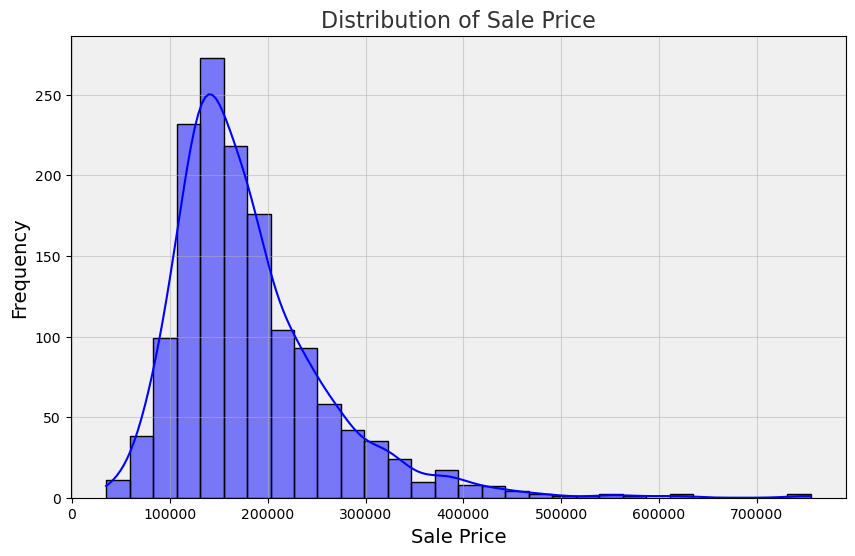

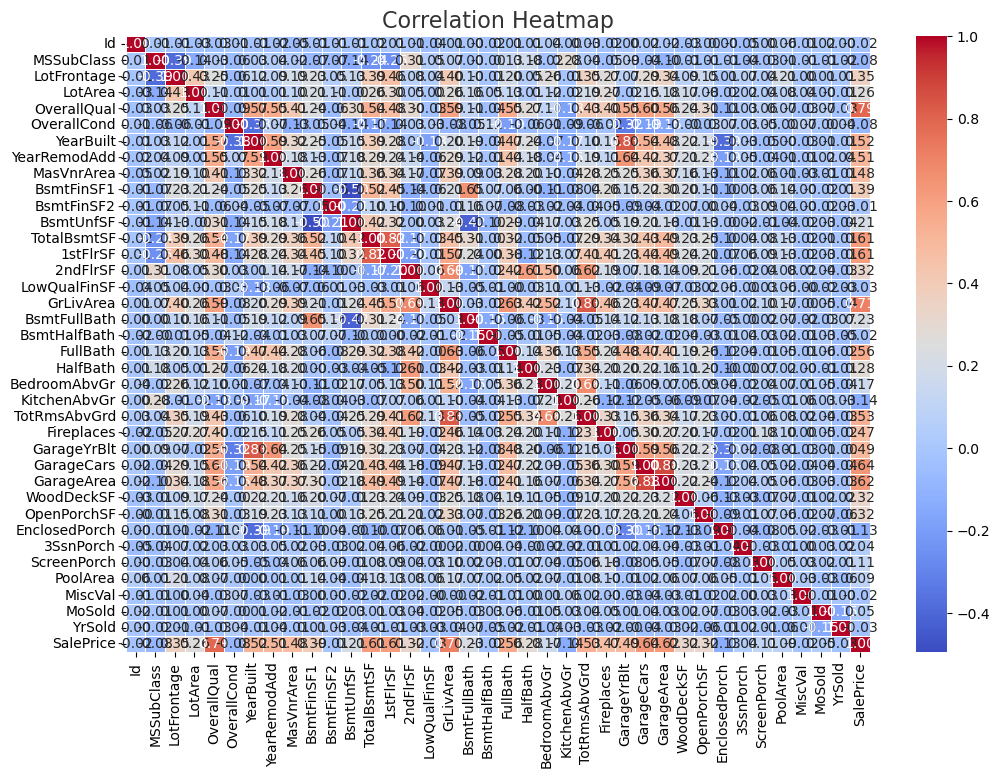

In [13]:
#Data visualization
# Plot the distribution of Sale Price
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, color='blue', bins=30)
plt.title('Distribution of Sale Price', fontsize=16, color='#333')
plt.xlabel('Sale Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.5)
plt.gca().set_facecolor('#f0f0f0')  
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_data = train_data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, linecolor='white')
plt.title('Correlation Heatmap', fontsize=16, color='#333')
plt.gca().set_facecolor('#f0f0f0') 
plt.show()


In [15]:
# Feature Engineering: Adding new features
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']


In [17]:
# Define features and target variable
X = train_data.drop(columns=['Id', 'SalePrice'])
y = train_data['SalePrice']

# Splitting the training data for model evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [ ]:
#Model training and evaluation
# Define models
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define models with increased max_iter for Ridge and Lasso
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(max_iter=50000, alpha=1.0), 
    'Lasso Regression': Lasso(max_iter=50000, alpha=0.01),  
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SGD Regression': SGDRegressor(max_iter=1000, tol=1e-3)
}

# Training and evaluating models
results = []

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = pipeline.predict(X_val)
    
    # Evaluate the model
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

# Display results
display(HTML("<h2 style='color: #4CAF50;'>Model Evaluation Results</h2>"))
display(HTML("<div style='background-color: #f9f9f9; padding: 10px; border-radius: 8px;'>"))
display(results_df.style.set_table_attributes('style="border-collapse:collapse; width: 100%;"')
                .set_table_styles([{
                    'selector': 'th',
                    'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]
                }, {
                    'selector': 'td',
                    'props': [('border', '1px solid #ddd')]
                }]))
display(HTML("</div>"))

In [17]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(Pipeline(steps=[('preprocessor', preprocessor),
                                           ('regressor', RandomForestRegressor())]),
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


In [18]:
# Prepare test data for prediction
X_test = test_data.drop(columns=['Id'])

# Predict and save the best model's results
y_test_pred = best_model.predict(X_test)

# Save predictions to a CSV file
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")


Predictions saved to 'submission.csv'
